# Calculation of the iso-$T_3^0/T_1^0$ lines on Compressor Map

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata, interp1d
import os

Function for reading `<component>_map/formatted_<values>.txt` files

In [16]:
def read_table(file_path):
    df = pd.read_csv(file_path, delim_whitespace=True, header=None)  # keep old style
    col_vals = df.iloc[0,1:].values
    row_vals = df.iloc[1:,0].values
    central_vals = df.iloc[1:,1:].values
    return col_vals, row_vals, central_vals

Read all the compressor files:

In [15]:
folder = "compressor_map"
beta_mf, speed_mf, mass_flow_vals = read_table(f"{folder}/formatted_mass_flow.txt")
beta_ip, speed_ip, iso_press_vals = read_table(f"{folder}/formatted_iso_pressure_ratio.txt")
beta_ie, speed_ie, iso_eff_vals = read_table(f"{folder}/formatted_iso_efficiency.txt")
surge_df = pd.read_csv(f"{folder}/formatted_surge_line.txt", delim_whitespace=True, header=None)

C:\Users\Lenovo1\AppData\Local\Temp\ipykernel_25096\2814595640.py:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)  # keep old style
C:\Users\Lenovo1\AppData\Local\Temp\ipykernel_25096\2814595640.py:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)  # keep old style
C:\Users\Lenovo1\AppData\Local\Temp\ipykernel_25096\2814595640.py:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)  # keep old style
C:\Users\Lenovo1\AppData\Local\Temp\ipykernel_25096\204106743.py:5: FutureWarning: The 'delim_whitespace' keywor

Post-processing and data interpolation:

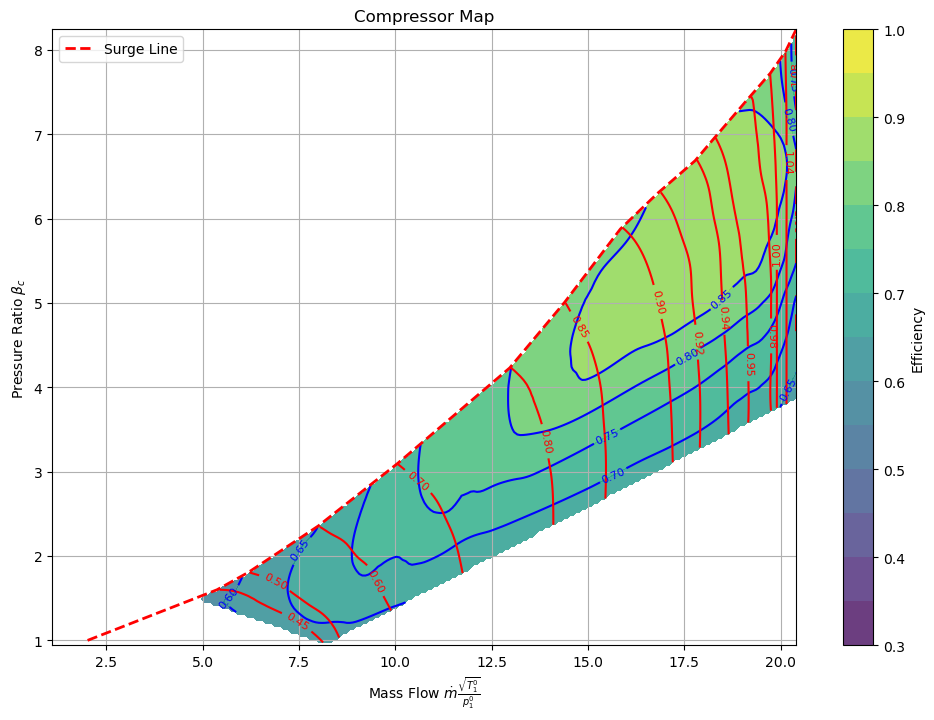

In [17]:
# -----------------------------
# Flatten arrays for interpolation
# -----------------------------
n_rows, n_cols = mass_flow_vals.shape
mf_flat = mass_flow_vals.flatten()
pr_flat = iso_press_vals.flatten()          # use actual pressure ratio values
eff_flat = iso_eff_vals.flatten()
speed_flat = np.repeat(speed_mf, n_cols)   # repeat speed along columns

# -----------------------------
# Regular grid for plotting
# -----------------------------
mf_grid, pr_grid = np.meshgrid(
    np.linspace(mf_flat.min(), mf_flat.max(), 200),
    np.linspace(pr_flat.min(), pr_flat.max(), 200)
)

# -----------------------------
# Interpolation on grid
# -----------------------------
eff_grid = griddata((mf_flat, pr_flat), eff_flat, (mf_grid, pr_grid), method='cubic')
speed_grid = griddata((mf_flat, pr_flat), speed_flat, (mf_grid, pr_grid), method='cubic')

# -----------------------------
# Surge line mask
# -----------------------------
surge_numbers = surge_df.values.flatten()
n = len(surge_numbers)//2
surge_X, surge_Y = surge_numbers[:n], surge_numbers[n:]
surge_interp = interp1d(surge_X, surge_Y, bounds_error=False, fill_value="extrapolate")
Y_surge_grid = surge_interp(mf_grid[0,:])
Y_mask_grid = pr_grid <= Y_surge_grid[np.newaxis, :]   # broadcast mask

# Apply mask
ISO_EFF_masked = np.where(Y_mask_grid, eff_grid, np.nan)
speed_grid_masked = np.where(Y_mask_grid, speed_grid, np.nan)

# -----------------------------
# Iso-efficiency contour
# -----------------------------
eff_levels = np.arange(0.3, 1.01, 0.05)
plt.figure(figsize=(12,8))
CF = plt.contourf(mf_grid, pr_grid, ISO_EFF_masked, levels=eff_levels, cmap="viridis", alpha=0.8)
plt.colorbar(CF, label="Efficiency")
CS_eff = plt.contour(mf_grid, pr_grid, ISO_EFF_masked, levels=eff_levels, colors='blue', linewidths=1.5)
plt.clabel(CS_eff, inline=True, fontsize=8, fmt="%.2f")

# -----------------------------
# Surge line plot
# -----------------------------
plt.plot(surge_X, surge_Y, 'r--', linewidth=2, label='Surge Line')

# -----------------------------
# Iso-N contour
# -----------------------------
cs = plt.contour(mf_grid, pr_grid, speed_grid_masked, levels=speed_mf, colors='r')
plt.clabel(cs, inline=True, fontsize=8, fmt="%1.2f")

# -----------------------------
# Labels and formatting
# -----------------------------
plt.xlabel(r"Mass Flow $\dot m \frac{\sqrt{T_1^0}}{p_1^0}$")
plt.ylabel(r"Pressure Ratio $\beta_c$")
plt.title("Compressor Map")
plt.grid(True)
plt.legend()
plt.show()


Read all the turbine files:

C:\Users\Lenovo1\AppData\Local\Temp\ipykernel_25096\4030266264.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)  # keep old style
C:\Users\Lenovo1\AppData\Local\Temp\ipykernel_25096\4030266264.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)  # keep old style


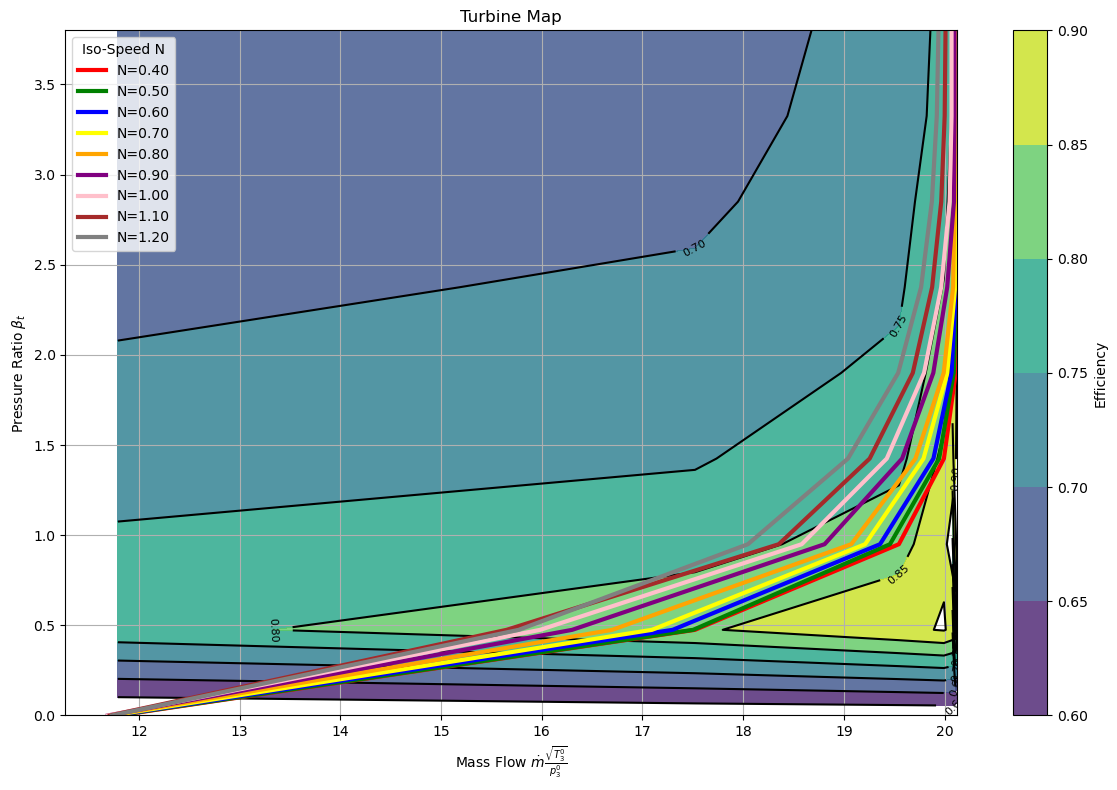

In [39]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

folder_base = "turbine_map"

# -----------------------------
# Read turbine mass flow
# -----------------------------
mf_file = os.path.join(folder_base, "formatted_mass_flow.txt")
beta_turb, speed_turb, mass_flow_turb = read_table(mf_file)

# Pressure ratio mapping (simple linear scaling)
PR_min, PR_max = 0, 3.8
PR_real = (PR_max - PR_min) / (beta_turb.max() - beta_turb.min()) * (beta_turb - beta_turb.min()) + PR_min

# -----------------------------
# Read iso-efficiency
# -----------------------------
ie_file = os.path.join(folder_base, "formatted_iso_efficiency.txt")
beta_eta, speed_eta, iso_eff_turb = read_table(ie_file)
PR_eta_real = (PR_max - PR_min) / (beta_eta.max() - beta_eta.min()) * (beta_eta - beta_eta.min()) + PR_min

# -----------------------------
# Convert speed N -> Mass Flow for iso-efficiency plotting
# -----------------------------
points = np.array([(PR_real[j], speed_turb[i]) for i in range(len(speed_turb)) for j in range(len(beta_turb))])
values = mass_flow_turb.flatten()

mass_flow_eta_turb = np.zeros_like(iso_eff_turb)
for i, N in enumerate(speed_eta):
    for j, PR in enumerate(PR_eta_real):
        mass_flow_eta_turb[i, j] = griddata(points, values, (PR, N), method='linear')

# -----------------------------
# Meshgrid for plotting
# -----------------------------
mf_t_grid, pr_t_grid = np.meshgrid(mass_flow_eta_turb[0,:], PR_eta_real)
iso_eff_sorted_turb = iso_eff_turb.T

# -----------------------------
# Turbine map plot
# -----------------------------
plt.figure(figsize=(12,8))

# Iso-efficiency contours
levels_eff = np.arange(0.6, 0.95, 0.05)
CF = plt.contourf(mf_t_grid, pr_t_grid, iso_eff_sorted_turb, levels=levels_eff, cmap="viridis", alpha=0.8)
plt.colorbar(CF, label="Efficiency")
CS = plt.contour(mf_t_grid, pr_t_grid, iso_eff_sorted_turb, levels=levels_eff, colors='k')
plt.clabel(CS, inline=True, fontsize=8, fmt="%.2f")

# Iso-speed N curves
colors = ["red","green","blue","yellow","orange","purple","pink","brown","gray"]
for i, N in enumerate(speed_turb):
    plt.plot(mass_flow_turb[i, :], PR_real, color=colors[i % len(colors)], label=f"N={N:.2f}", lw=3)

# -----------------------------
# Labels and formatting
# -----------------------------
plt.xlabel(r"Mass Flow $\dot m \frac{\sqrt{T_3^0}}{p_3^0}$")
plt.ylabel(r"Pressure Ratio $\beta_t$")
plt.title("Turbine Map")
plt.grid(True)
plt.legend(title="Iso-Speed N", loc='upper left')
plt.tight_layout()
plt.show()


Post-processing and data interpolation:

## Turbine/Compressor Matching

1. Take a point on the compressor map and retrieve the associated values of corrected speed `N_corr` and compressor efficiency `η_c`.  
2. Assume a trial value for the temperature ratio `T3/T1`.  
3. Use this assumed `T3/T1` to retrieve a point on the turbine map, applying the congruence equations (mass and rpm conservations).  
4. Check the pressure congruence between compressor outlet and turbine inlet/outlet.  
5. Iterate adjusting `T3/T1` until pressure congruence is satisfied.


In [29]:
# Constants definition

epsilon_b = 0.99 # [-] Combustor pressure ratio TODO: implement combustor map

epislon_d = 0.99 # [-] Air intake pressure ratio TODO: implement air intake map

beta_n = 2.5 # [-] Nozzle pressure ratio TODO: implement nozzle map

M0 = 0.3 # [-] Assumed aircraft Mach number (actually is an input from the game)

gamma = 1.4 # [-] Air specific heat ratio cp/cv


### Step 1: Take a point on the compressor map

### Step 2: Assume a trail value for `T3/T1`

In [64]:
# Assicurati che siano array numpy float64
ISO_EFF_masked = np.array(ISO_EFF_masked, dtype=np.float64)
speed_grid_masked = np.array(speed_grid_masked, dtype=np.float64)

# Maschera dei valori validi
valid_mask = ~np.isnan(ISO_EFF_masked) & ~np.isnan(speed_grid_masked)
valid_indices = list(zip(*np.where(valid_mask)))

# Prealloca array per salvare il miglior temp_ratio per ogni punto
best_temp_ratios = np.full(ISO_EFF_masked.shape, np.nan)
best_differences = np.full(ISO_EFF_masked.shape, np.nan)

# Itera solo sui punti validi
total_points = len(valid_indices)
for count, (i, j) in enumerate(valid_indices, start=1):
    # Stampa lo stato di avanzamento
    print(f"Processing point {count}/{total_points} -> index (i={i}, j={j})")

    differences = []
    temp_ratios_list = []

    for temp_ratio in np.arange(1, 5, 0.1):
        mf_turb = mf_grid[i, j] * np.sqrt(temp_ratio) / pr_grid[i, j] / epsilon_b
        N_corr_turb = speed_grid_masked[i, j] / np.sqrt(temp_ratio)

        # Flatten delle griglie
        mf_flat = mf_grid.flatten()
        pr_flat = pr_grid.flatten()
        speed_flat = speed_grid_masked.flatten()
        eff_flat = ISO_EFF_masked.flatten()

        distances = np.sqrt((mf_flat - mf_turb)**2 + (speed_flat - N_corr_turb)**2)
        idx_min = np.argmin(distances)

        closest_beta = pr_flat[idx_min]

        # Calcolo LHS e RHS
        LHS_pressure_eq = (1 + (gamma - 1) / 2 * M0 ** 2) ** (gamma / (gamma - 1)) * epislon_d * pr_grid[i, j]
        RHS_pressure_eq = closest_beta * beta_n / epsilon_b

        differences.append(abs(LHS_pressure_eq - RHS_pressure_eq))
        temp_ratios_list.append(temp_ratio)

    # Salva il temp_ratio con differenza minima
    min_idx = np.argmin(differences)
    best_temp_ratios[i, j] = temp_ratios_list[min_idx]
    best_differences[i, j] = differences[min_idx]


Processing point 1/11922 -> index (i=1, j=45)
Processing point 2/11922 -> index (i=1, j=46)
Processing point 3/11922 -> index (i=1, j=47)
Processing point 4/11922 -> index (i=1, j=48)
Processing point 5/11922 -> index (i=1, j=49)
Processing point 6/11922 -> index (i=2, j=42)
Processing point 7/11922 -> index (i=2, j=43)
Processing point 8/11922 -> index (i=2, j=44)
Processing point 9/11922 -> index (i=2, j=45)
Processing point 10/11922 -> index (i=2, j=46)
Processing point 11/11922 -> index (i=2, j=47)
Processing point 12/11922 -> index (i=2, j=48)
Processing point 13/11922 -> index (i=2, j=49)
Processing point 14/11922 -> index (i=2, j=50)
Processing point 15/11922 -> index (i=2, j=51)
Processing point 16/11922 -> index (i=3, j=39)
Processing point 17/11922 -> index (i=3, j=40)
Processing point 18/11922 -> index (i=3, j=41)
Processing point 19/11922 -> index (i=3, j=42)
Processing point 20/11922 -> index (i=3, j=43)
Processing point 21/11922 -> index (i=3, j=44)
Processing point 22/11

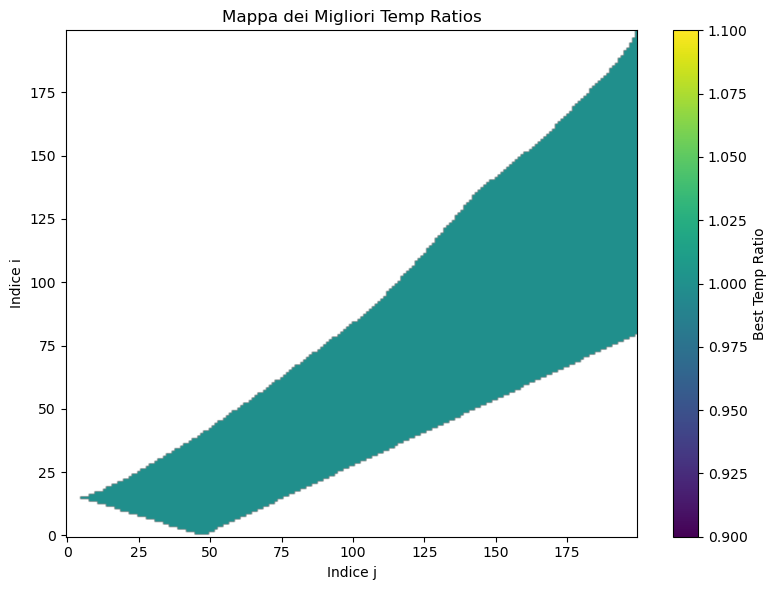

In [65]:

# Visualizza la mappa dei migliori temp_ratios
plt.figure(figsize=(8, 6))
plt.imshow(best_temp_ratios, cmap='viridis', origin='lower', aspect='auto')
plt.colorbar(label='Best Temp Ratio')
plt.title('Mappa dei Migliori Temp Ratios')
plt.xlabel('Indice j')
plt.ylabel('Indice i')
plt.tight_layout()
plt.show()